In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from google.colab import files

In [ ]:
# Getting the data from csv file. The data should be in the form
# surge_mean  sway_mean  VVEL   VDIR   HS1  TP1  DIR1  CVEL0  CDIR0
# Where surge_mean and sway mean are the outputs, the remaining collumns are the input
df = pd.read_csv(r"..\PreProcessamentoDados\Data.csv")

# getting the inputs and outups from dataframe
inputs = df[["VVEL", "VDIR", "HS1", "TP1", "DIR1", "CVEL0", "CDIR0"]]
outputs = df[["surge_mean", "sway_mean"]]

# passing the data to numpy
inputs_array = inputs.to_numpy(copy=True, dtype='float' , na_value=np.nan)
outputs_array = outputs.to_numpy(copy=True, dtype='float', na_value=np.nan)

# passing the data to tensor
inputs_tensor = torch.from_numpy(inputs_array).type(torch.float)
outputs_tensor = torch.from_numpy(outputs_array).type(torch.float).reshape(-1, 2)

In [ ]:
## Defining the models architectures, losses and optimizers

# First model
model1 = nn.Sequential(
    nn.Linear(7, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)
# Loss and Optmizer
criterion1 = nn.MSELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.1)

# Second model
model2 = nn.Sequential(
    nn.Linear(7, 100),
    nn.ReLU(),
    nn.Linear(100, 300),
    nn.ReLU(),
    nn.Linear(300, 500),
    nn.ReLU(),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 2)
)
# Loss and Optmizer
criterion2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

# Third Model
model3 = nn.Sequential(
    nn.Linear(7, 100),
    nn.ReLU(),
    nn.Linear(100, 300),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(300, 500),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(500, 300),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 2)
)

# Loss and Optmizer
criterion3 = nn.MSELoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
# choosing the device so the gpu could be used
device = "gpu"

device = torch.device("cuda:0" if device == "gpu" and torch.cuda.is_available() else "cpu")

models = [model1, model2, model3]

# Putting models into device
for model in models:
  model.to(device)
  model.to(torch.float32)

# Putting data into device. Model and data needs to be in the same device for calculations
inputs_tensor = inputs_tensor.to(device)
outputs_tensor = outputs_tensor.to(device)

# placing a seed so the results maintain constant
seed = 21
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Defining the training function
def full_gd(model, criterion, optimizer, X_train, X_test, y_train, y_test, epochs=1500):
  # starting arrats to stores losses
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # Putting the model in training mode if for some reason it was passed in eval mode
  model.train()

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # predicting for test each iteration
    # Putting the model in eval so the test is done properly. e.g. dropout is deactivated
    model.eval()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

    # Putting the model back to training mode
    model.train()

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()
    test_losses[it] = test_loss.item()

  return train_losses, test_losses

In [ ]:
# Functions to evaluate the model
def evaluate_loss(model, criterion, X, y):
  # Evaluate the loss based on criterion for X (inputs) and y (outputs) given model
  model.eval()  # Model must be on evaluatiuon step to do the proper calcultaions
  with torch.no_grad():
    y_pred = model(X)
    loss = criterion(y, y_pred).item()

  return loss


def evaluate_r2_score(model, X, y):
  # Evaluate the r2-score based for X (inputs) and y (outputs) given model
  model.eval() # Model must be on evaluatiuon step to do the proper calcultaions
  with torch.no_grad():
    y_pred = model(X)

  # Passing data back to cpu
  y, y_pred = y.cpu(), y_pred.cpu()

  # Calculate R2 score
  r2 = r2_score(y, y_pred)

  return r2

def weight_reset(m):
  # this function aims to reset the parameters of a model bust remains it architecture
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

def sensitive_analysis(model, criterion, optimizer, X_train, X_test, y_train, y_test):
  # This analysis consist in varying the number of samples in data set and evaluate it with r2-score

  # define a seed so the same results can be reproduced
  random.seed(0)

  # define number of samples to consider
  max_samples = X_train.size(0)

  sizes = list(range(0,max_samples, 200))

  r2_train_saves, r2_test_saves = [], []
  for sample_size in sizes:
    # reseting model weights so a new model will ran
    model.apply(weight_reset)

    #creating random samples with specific sample size
    indexes = random.sample(range(max_samples), sample_size)
    X_train_sample, y_train_sample = X_train[indexes], y_train[indexes]


    train_losses, test_losses = full_gd(model, criterion, optimizer, X_train_sample, X_test, y_train_sample, y_test)


    r2_train = evaluate_r2_score(model, X_train, y_train)
    r2_test = evaluate_r2_score(model, X_test, y_test)

    r2_train_saves.append(r2_train)
    r2_test_saves.append(r2_test)

  return r2_train_saves, r2_test_saves, sizes

In [ ]:

def saving_all(models, criterions, optimizers, inputs_tensor, outputs_tensor, test_size, seed):
  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(inputs_tensor, outputs_tensor, test_size=test_size/100, random_state=seed)


  # Initialize the StandardScaler. It must come only from the train
  X_mean, X_std = X_train.mean(dim=0, keepdim=True), X_train.std(dim=0, keepdim=True)
  y_mean, y_std  = y_train.mean(dim=0, keepdim=True), y_train.std(dim=0, keepdim=True)

  # Applying on training and test
  X_train = (X_train - X_mean)/ X_std
  y_train = (y_train - y_mean)/ y_std

  X_test = (X_test - X_mean)/ X_std
  y_test = (y_test - y_mean)/ y_std

  # folder name to save figures
  folder_name = f'{test_size} Test - Seed {seed}'

  # The exist_ok=True parameter allows the command to succeed even if the folder already exists,
  # preventing an error from being raised in that case.
  os.makedirs(folder_name, exist_ok=True)


  model_number = 0
  all_results = ""
  for model, criterion, optimizer in zip(models, criterions, optimizers):
    # reseting model weights so it will not run the model again when this cell run again
    model.apply(weight_reset)

    model_number += 1

    train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, X_test, y_train, y_test)


    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"{folder_name}/Modelo {model_number} -  Loss x Epoch  - {test_size} Test - Seed {seed}.png")
    plt.show()

    # Evaluate on Train Data and test data in terms of loss
    train_loss = evaluate_loss(model, criterion, X_train, y_train)
    test_loss = evaluate_loss(model, criterion, X_test, y_test)

    print(f'Train Loss: {train_loss:.4f}')
    print(f'Test Loss: {test_loss:.4f}')

    r2_train = evaluate_r2_score(model, X_train, y_train)
    r2_test = evaluate_r2_score(model, X_test, y_test)

    print(f'Train R-2 Score: {r2_train :.4f}')
    print(f'Test R-2 Score: {r2_test:.4f}')

    r2_sensitive_train, r_sensitive_test, sizes = sensitive_analysis(model, criterion, optimizer, X_train, X_test, y_train, y_test)

    # Plot the r2-score per sample size
    plt.plot(sizes, r2_sensitive_train, label='train r2')
    plt.plot(sizes, r_sensitive_test, label='test r2')
    plt.xlabel('Train Sample Size')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.savefig(f"{folder_name}/Modelo {model_number} -  R2 x Train Sample  - {test_size} Test - Seed {seed}.png")
    plt.show()

    # Format the results for this model
    write_str = f"""Modelo {model_number}

  Train Loss: {train_loss:.4f}
  Test Loss: {test_loss:.4f}
  Train R-2 Score: {r2_train:.4f}
  Test R-2 Score: {r2_test:.4f}

  ------------------------
  """

    # Add the results for this model to the all_results string
    all_results += write_str

  # Save the all_results string to a text file
  with open(f'{folder_name}/{test_size} Test - Seed {seed}.txt', 'w') as file:
      file.write(all_results)

  folder_name = f'{test_size} Test - Seed {seed}'

  # Check if the folder exists
  if os.path.exists(folder_name):
      # Create a zip file from the folder, making sure to quote the folder name to handle spaces/special characters
      zip_file_name = f'"{folder_name}.zip"'
      folder_name_quoted = f'"{folder_name}"'
      !zip -r {zip_file_name} {folder_name_quoted}

      # Download the zip file
      files.download(zip_file_name.strip('"')) # Remove quotes before using in download
  else:
      print(f"The folder '{folder_name}' does not exist in the current directory.")

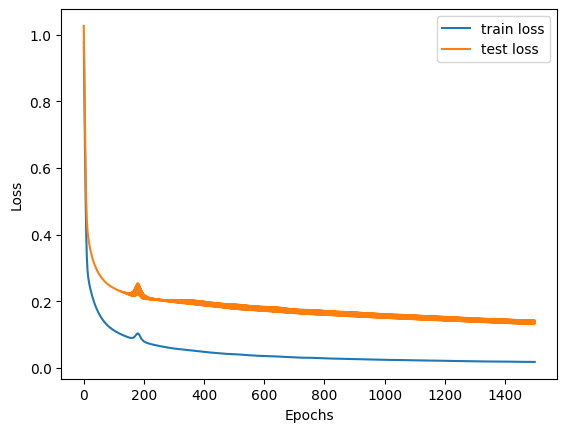

Train Loss: 0.0179
Test Loss: 0.1312
Train R-2 Score: 0.9821
Test R-2 Score: 0.8749


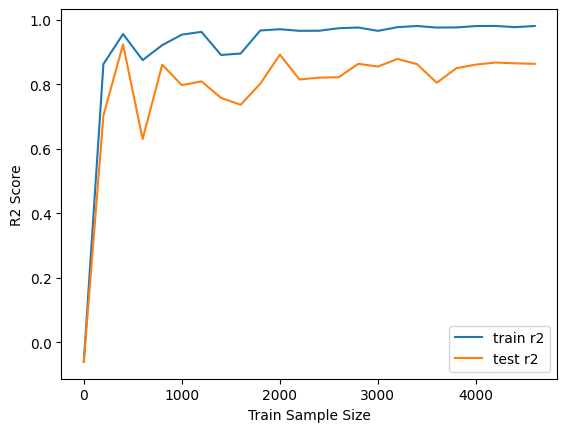

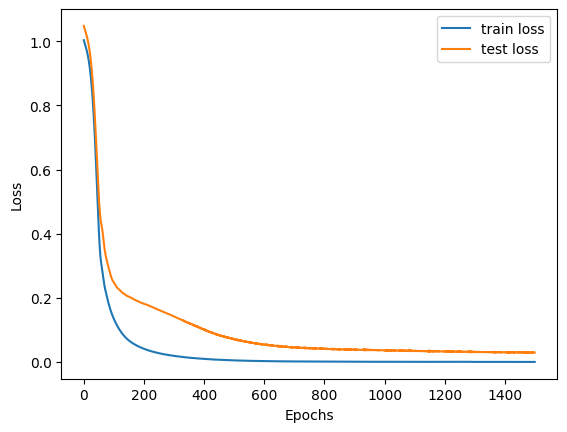

Train Loss: 0.0005
Test Loss: 0.0300
Train R-2 Score: 0.9995
Test R-2 Score: 0.9714


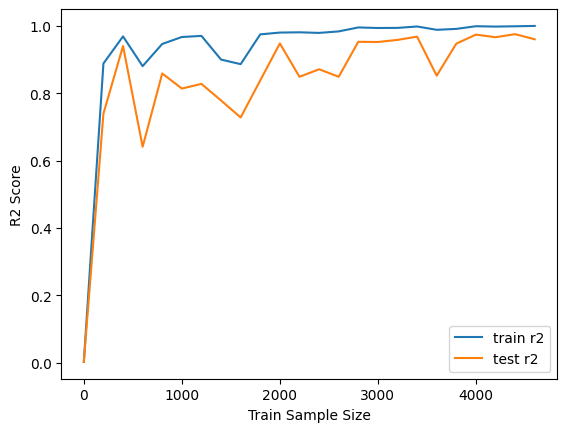

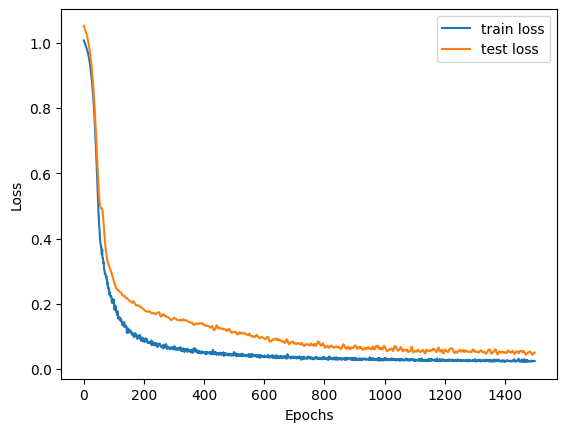

Train Loss: 0.0035
Test Loss: 0.0502
Train R-2 Score: 0.9965
Test R-2 Score: 0.9521


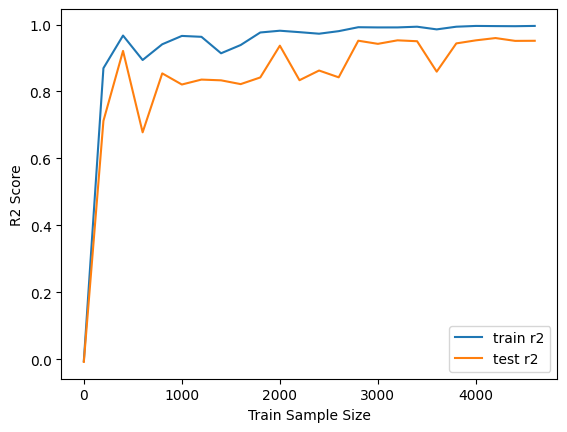

  adding: 10 Test - Seed 31/ (stored 0%)
  adding: 10 Test - Seed 31/Modelo 3 -  R2 x Train Sample  - 10 Test - Seed 31.png (deflated 8%)
  adding: 10 Test - Seed 31/Modelo 3 -  Loss x Epoch  - 10 Test - Seed 31.png (deflated 8%)
  adding: 10 Test - Seed 31/Modelo 2 -  R2 x Train Sample  - 10 Test - Seed 31.png (deflated 8%)
  adding: 10 Test - Seed 31/Modelo 1 -  R2 x Train Sample  - 10 Test - Seed 31.png (deflated 8%)
  adding: 10 Test - Seed 31/Modelo 1 -  Loss x Epoch  - 10 Test - Seed 31.png (deflated 9%)
  adding: 10 Test - Seed 31/10 Test - Seed 31.txt (deflated 68%)
  adding: 10 Test - Seed 31/Modelo 2 -  Loss x Epoch  - 10 Test - Seed 31.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

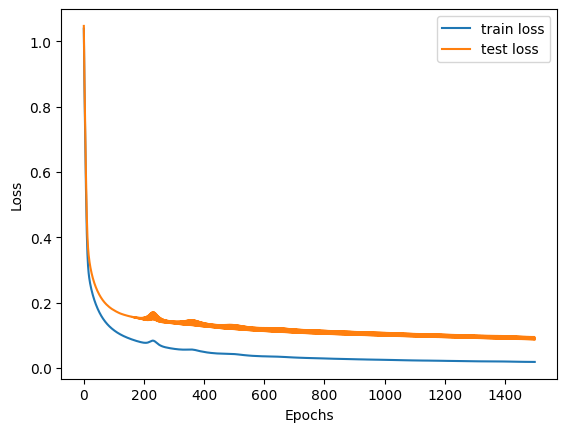

Train Loss: 0.0186
Test Loss: 0.0950
Train R-2 Score: 0.9814
Test R-2 Score: 0.9066


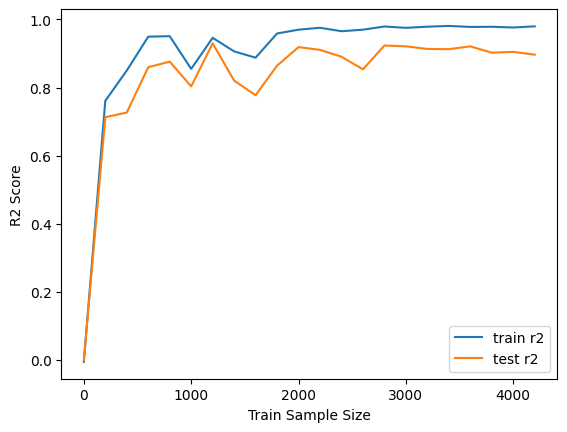

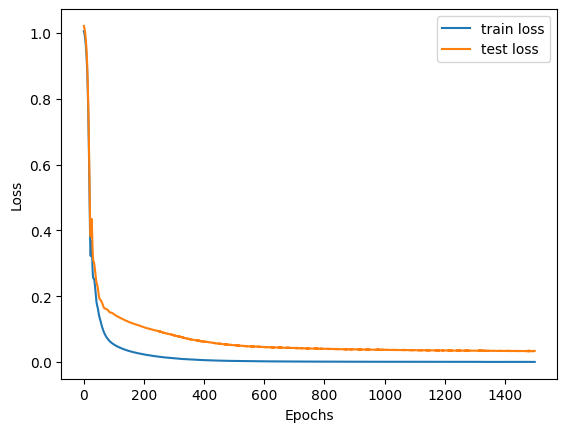

Train Loss: 0.0006
Test Loss: 0.0331
Train R-2 Score: 0.9994
Test R-2 Score: 0.9675


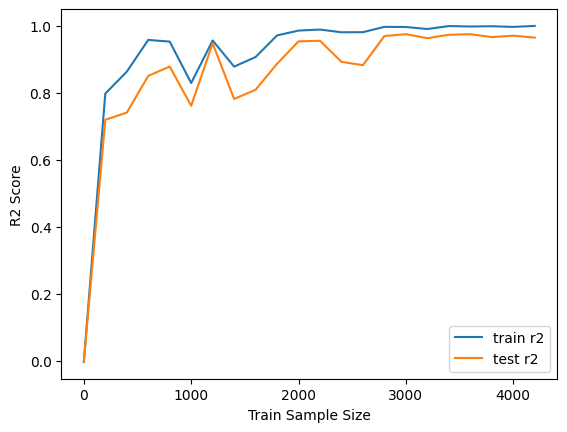

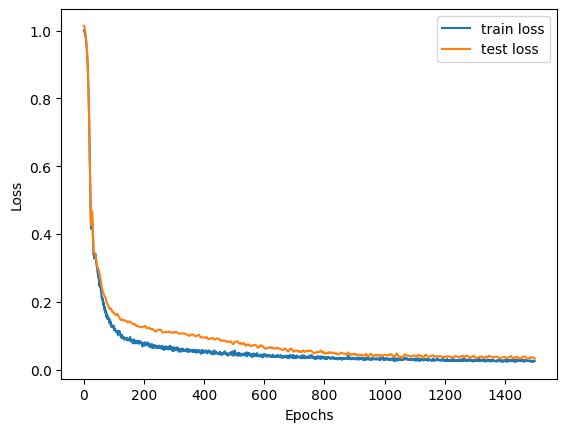

Train Loss: 0.0036
Test Loss: 0.0333
Train R-2 Score: 0.9964
Test R-2 Score: 0.9672


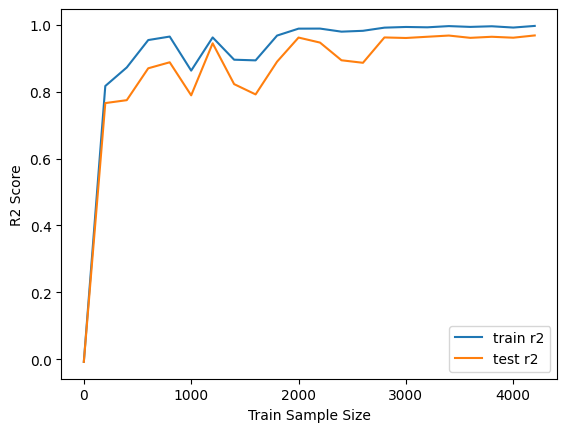

  adding: 15 Test - Seed 31/ (stored 0%)
  adding: 15 Test - Seed 31/Modelo 1 -  R2 x Train Sample  - 15 Test - Seed 31.png (deflated 9%)
  adding: 15 Test - Seed 31/Modelo 2 -  R2 x Train Sample  - 15 Test - Seed 31.png (deflated 8%)
  adding: 15 Test - Seed 31/15 Test - Seed 31.txt (deflated 71%)
  adding: 15 Test - Seed 31/Modelo 3 -  R2 x Train Sample  - 15 Test - Seed 31.png (deflated 9%)
  adding: 15 Test - Seed 31/Modelo 2 -  Loss x Epoch  - 15 Test - Seed 31.png (deflated 9%)
  adding: 15 Test - Seed 31/Modelo 1 -  Loss x Epoch  - 15 Test - Seed 31.png (deflated 10%)
  adding: 15 Test - Seed 31/Modelo 3 -  Loss x Epoch  - 15 Test - Seed 31.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

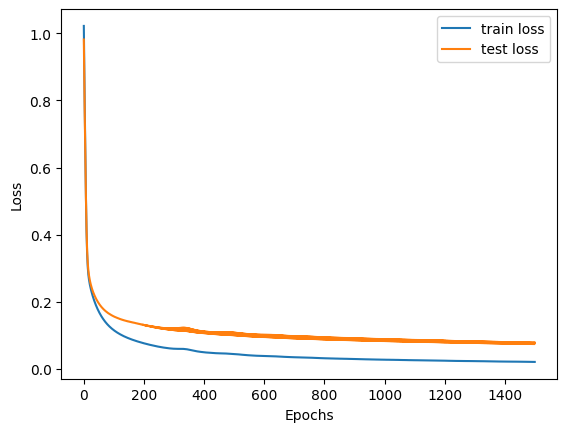

Train Loss: 0.0200
Test Loss: 0.0730
Train R-2 Score: 0.9800
Test R-2 Score: 0.9232


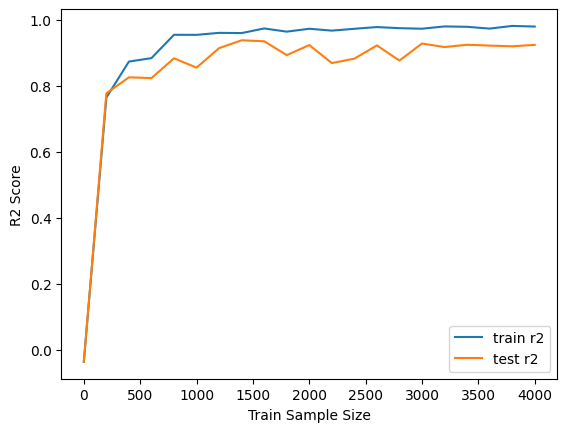

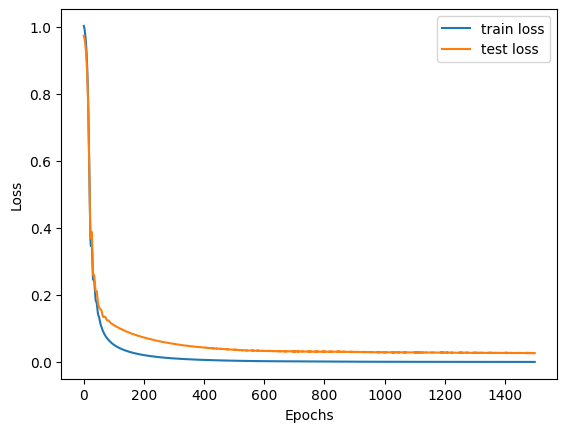

Train Loss: 0.0005
Test Loss: 0.0270
Train R-2 Score: 0.9995
Test R-2 Score: 0.9715


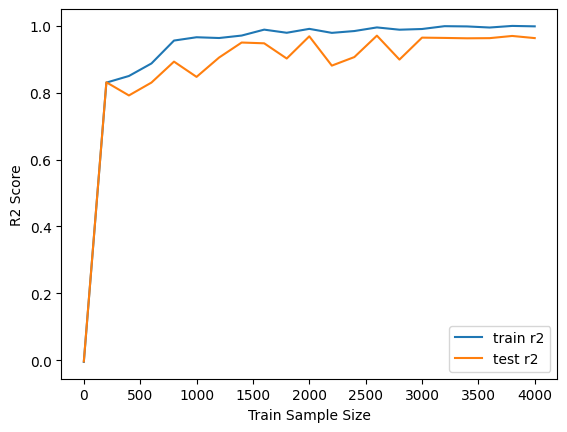

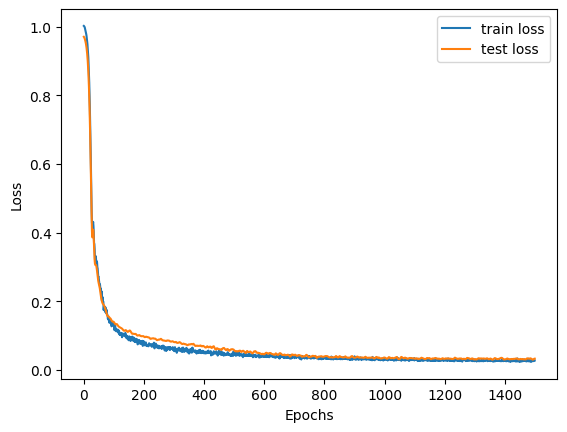

Train Loss: 0.0030
Test Loss: 0.0320
Train R-2 Score: 0.9970
Test R-2 Score: 0.9665


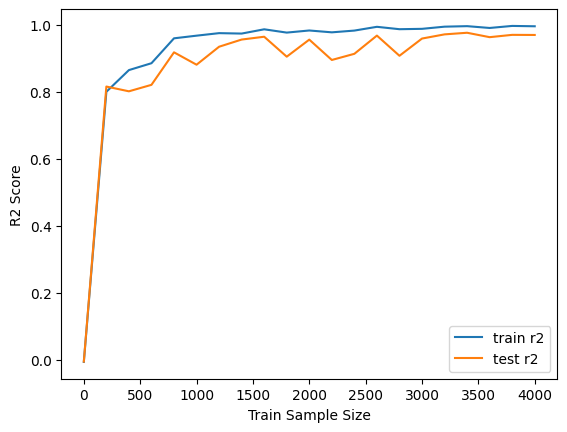

  adding: 20 Test - Seed 31/ (stored 0%)
  adding: 20 Test - Seed 31/Modelo 2 -  Loss x Epoch  - 20 Test - Seed 31.png (deflated 10%)
  adding: 20 Test - Seed 31/Modelo 3 -  R2 x Train Sample  - 20 Test - Seed 31.png (deflated 10%)
  adding: 20 Test - Seed 31/Modelo 1 -  Loss x Epoch  - 20 Test - Seed 31.png (deflated 10%)
  adding: 20 Test - Seed 31/Modelo 1 -  R2 x Train Sample  - 20 Test - Seed 31.png (deflated 9%)
  adding: 20 Test - Seed 31/Modelo 2 -  R2 x Train Sample  - 20 Test - Seed 31.png (deflated 10%)
  adding: 20 Test - Seed 31/Modelo 3 -  Loss x Epoch  - 20 Test - Seed 31.png (deflated 10%)
  adding: 20 Test - Seed 31/20 Test - Seed 31.txt (deflated 70%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

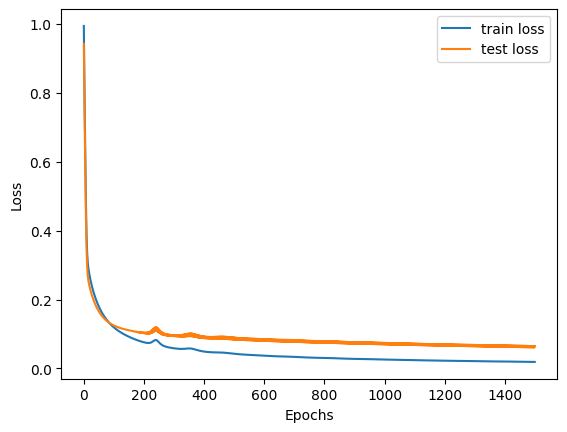

Train Loss: 0.0187
Test Loss: 0.0608
Train R-2 Score: 0.9813
Test R-2 Score: 0.9332


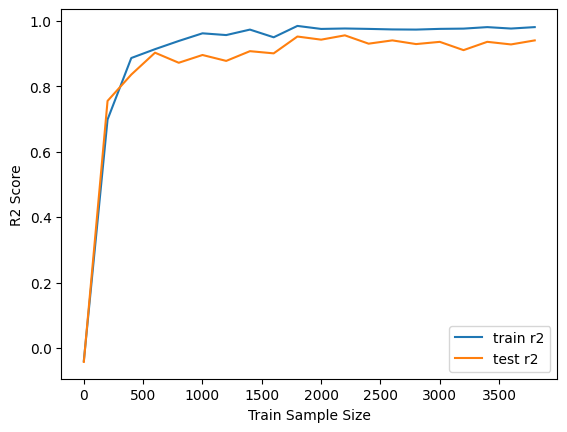

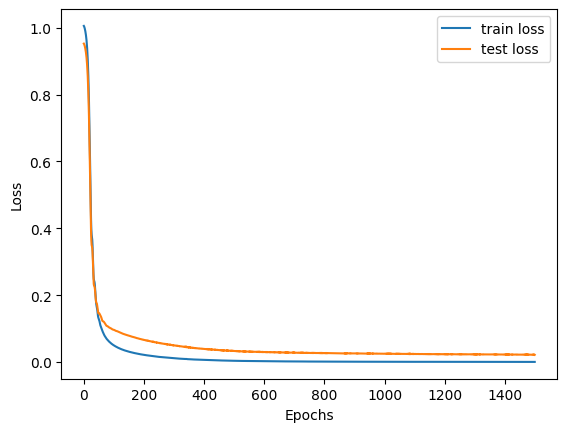

Train Loss: 0.0006
Test Loss: 0.0225
Train R-2 Score: 0.9994
Test R-2 Score: 0.9752


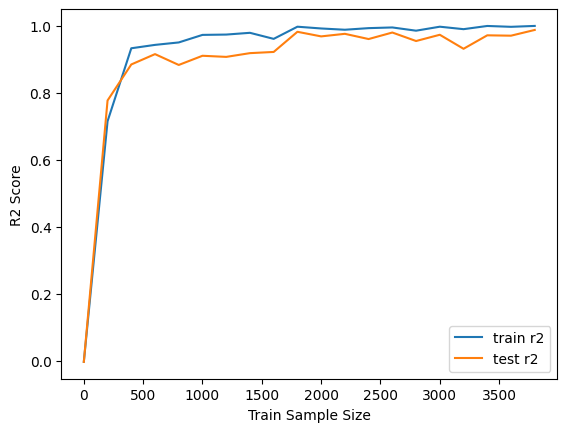

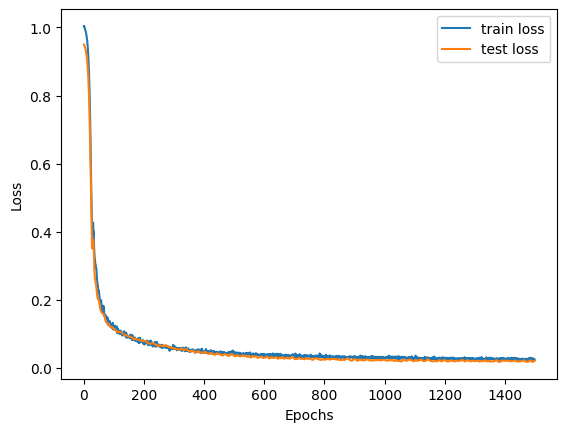

Train Loss: 0.0035
Test Loss: 0.0217
Train R-2 Score: 0.9965
Test R-2 Score: 0.9764


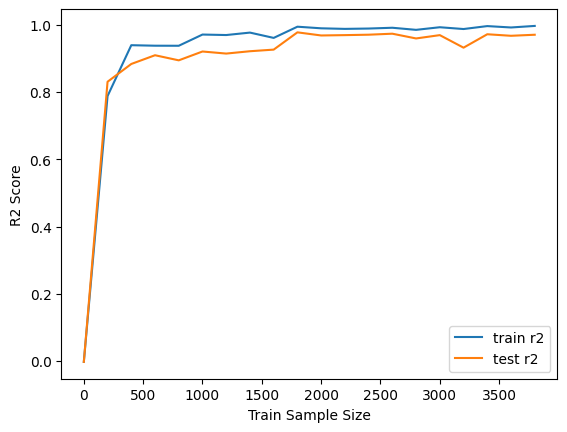

  adding: 25 Test - Seed 31/ (stored 0%)
  adding: 25 Test - Seed 31/Modelo 3 -  Loss x Epoch  - 25 Test - Seed 31.png (deflated 10%)
  adding: 25 Test - Seed 31/Modelo 3 -  R2 x Train Sample  - 25 Test - Seed 31.png (deflated 10%)
  adding: 25 Test - Seed 31/25 Test - Seed 31.txt (deflated 69%)
  adding: 25 Test - Seed 31/Modelo 1 -  Loss x Epoch  - 25 Test - Seed 31.png (deflated 11%)
  adding: 25 Test - Seed 31/Modelo 2 -  Loss x Epoch  - 25 Test - Seed 31.png (deflated 10%)
  adding: 25 Test - Seed 31/Modelo 1 -  R2 x Train Sample  - 25 Test - Seed 31.png (deflated 10%)
  adding: 25 Test - Seed 31/Modelo 2 -  R2 x Train Sample  - 25 Test - Seed 31.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

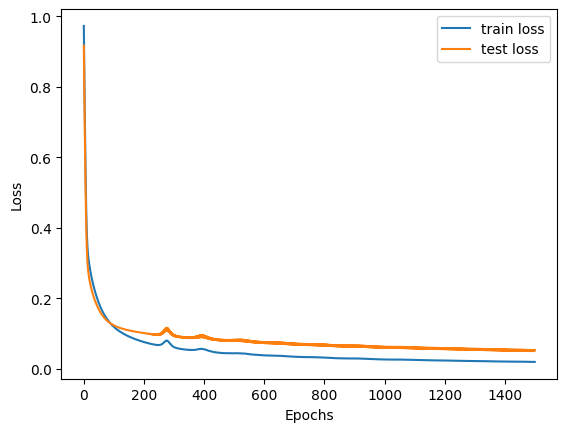

Train Loss: 0.0198
Test Loss: 0.0503
Train R-2 Score: 0.9802
Test R-2 Score: 0.9440


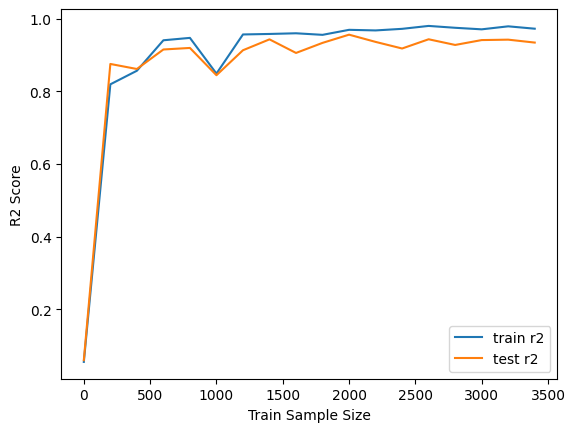

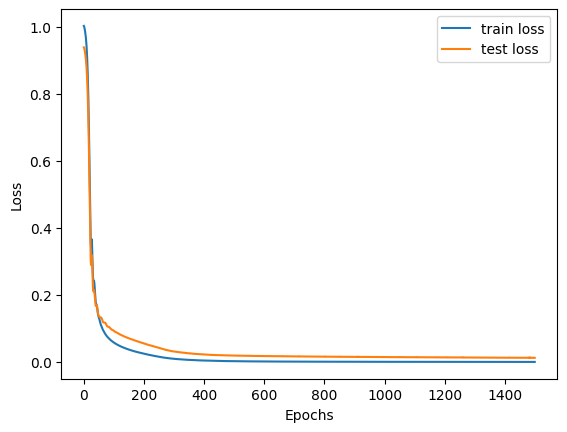

Train Loss: 0.0004
Test Loss: 0.0128
Train R-2 Score: 0.9996
Test R-2 Score: 0.9857


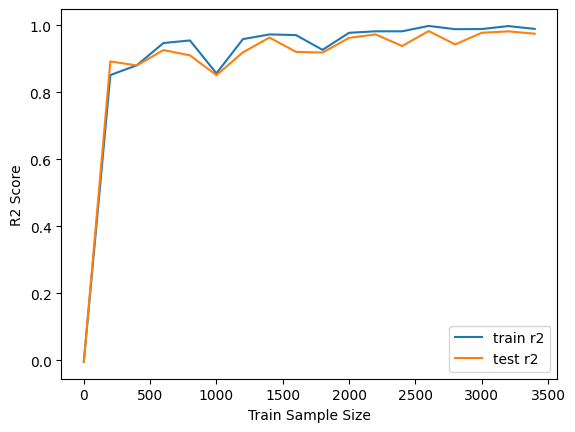

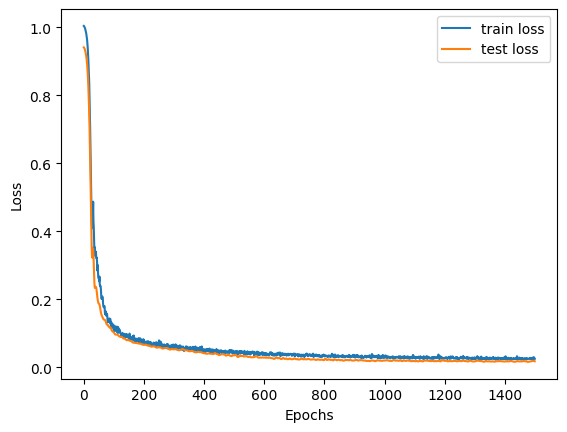

Train Loss: 0.0029
Test Loss: 0.0180
Train R-2 Score: 0.9971
Test R-2 Score: 0.9802


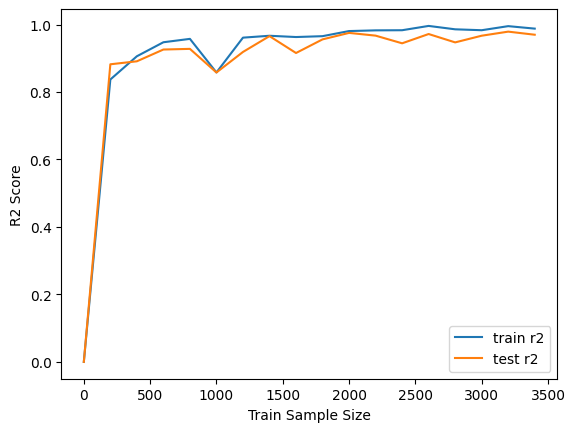

  adding: 30 Test - Seed 31/ (stored 0%)
  adding: 30 Test - Seed 31/Modelo 1 -  Loss x Epoch  - 30 Test - Seed 31.png (deflated 10%)
  adding: 30 Test - Seed 31/Modelo 2 -  R2 x Train Sample  - 30 Test - Seed 31.png (deflated 9%)
  adding: 30 Test - Seed 31/Modelo 1 -  R2 x Train Sample  - 30 Test - Seed 31.png (deflated 9%)
  adding: 30 Test - Seed 31/Modelo 3 -  R2 x Train Sample  - 30 Test - Seed 31.png (deflated 9%)
  adding: 30 Test - Seed 31/Modelo 2 -  Loss x Epoch  - 30 Test - Seed 31.png (deflated 11%)
  adding: 30 Test - Seed 31/30 Test - Seed 31.txt (deflated 69%)
  adding: 30 Test - Seed 31/Modelo 3 -  Loss x Epoch  - 30 Test - Seed 31.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

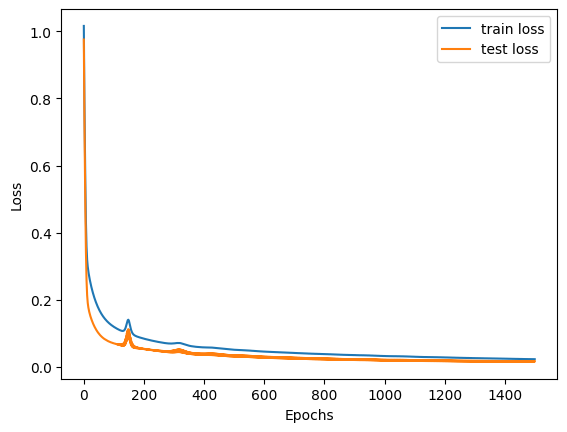

Train Loss: 0.0229
Test Loss: 0.0147
Train R-2 Score: 0.9771
Test R-2 Score: 0.9847


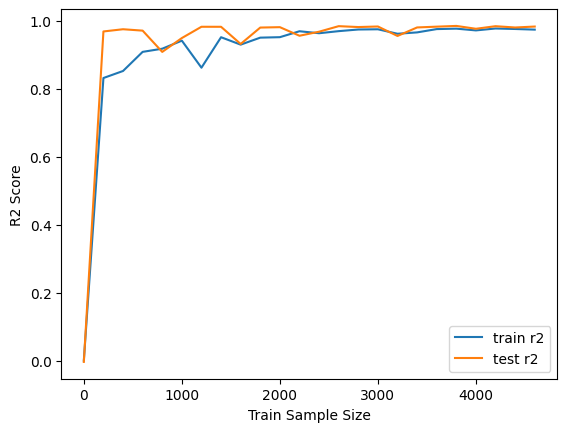

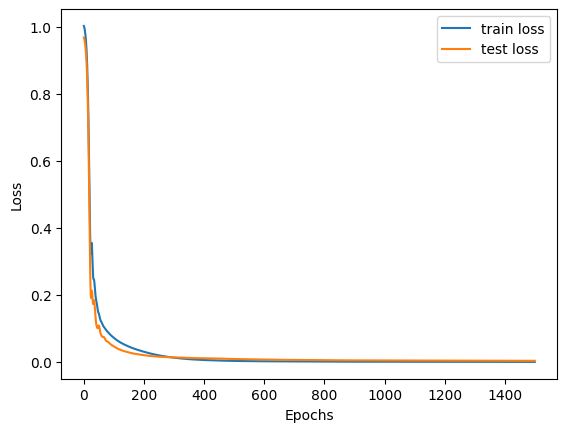

Train Loss: 0.0007
Test Loss: 0.0039
Train R-2 Score: 0.9993
Test R-2 Score: 0.9959


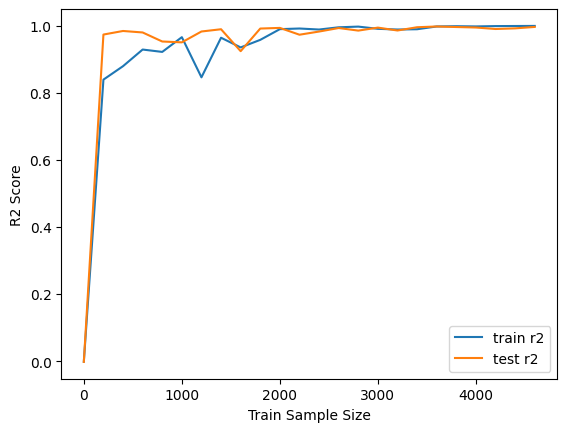

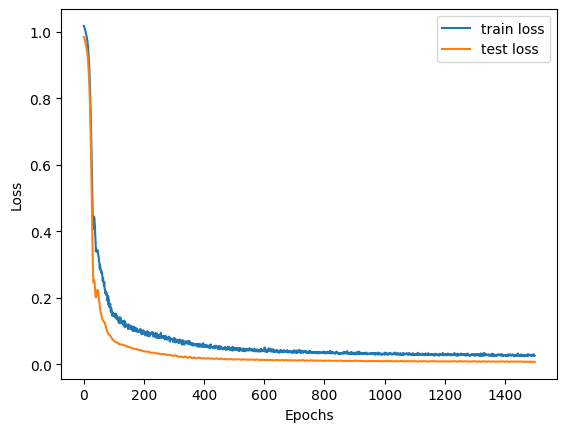

Train Loss: 0.0032
Test Loss: 0.0073
Train R-2 Score: 0.9968
Test R-2 Score: 0.9924


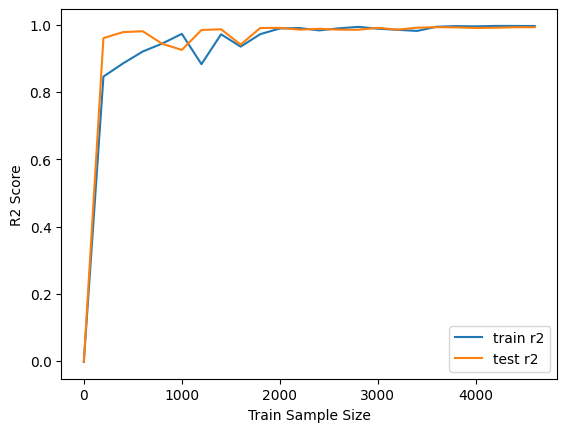

  adding: 10 Test - Seed 83/ (stored 0%)
  adding: 10 Test - Seed 83/Modelo 3 -  R2 x Train Sample  - 10 Test - Seed 83.png (deflated 10%)
  adding: 10 Test - Seed 83/Modelo 1 -  R2 x Train Sample  - 10 Test - Seed 83.png (deflated 10%)
  adding: 10 Test - Seed 83/Modelo 3 -  Loss x Epoch  - 10 Test - Seed 83.png (deflated 10%)
  adding: 10 Test - Seed 83/Modelo 2 -  Loss x Epoch  - 10 Test - Seed 83.png (deflated 11%)
  adding: 10 Test - Seed 83/Modelo 2 -  R2 x Train Sample  - 10 Test - Seed 83.png (deflated 10%)
  adding: 10 Test - Seed 83/10 Test - Seed 83.txt (deflated 69%)
  adding: 10 Test - Seed 83/Modelo 1 -  Loss x Epoch  - 10 Test - Seed 83.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

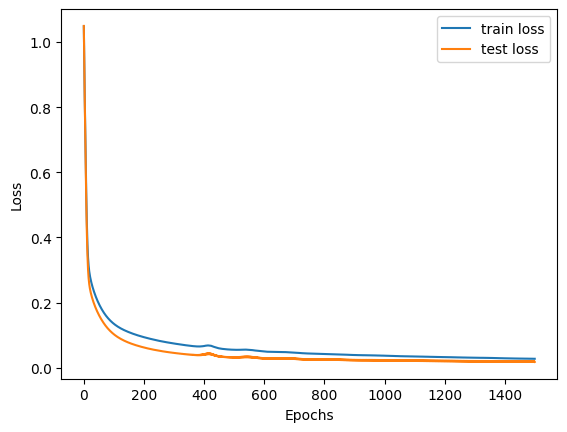

Train Loss: 0.0276
Test Loss: 0.0199
Train R-2 Score: 0.9724
Test R-2 Score: 0.9802


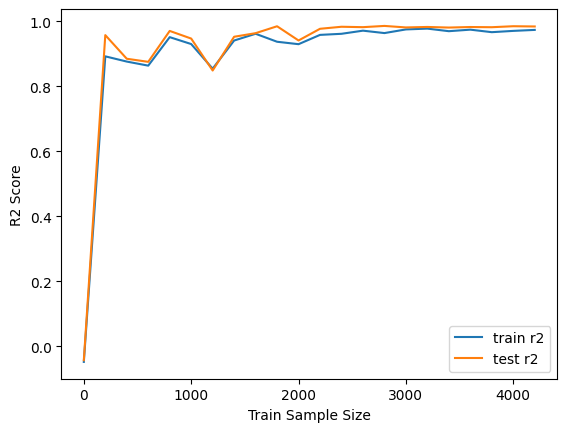

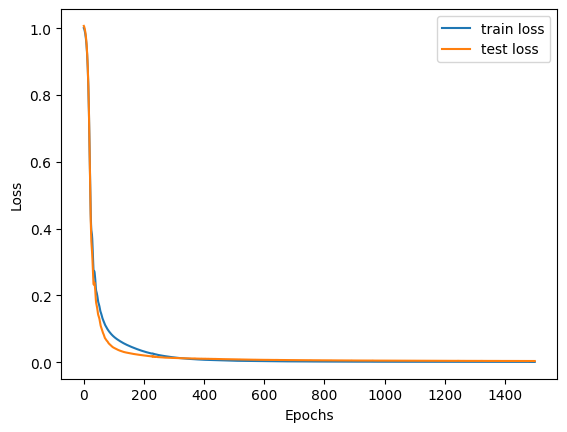

Train Loss: 0.0007
Test Loss: 0.0034
Train R-2 Score: 0.9993
Test R-2 Score: 0.9966


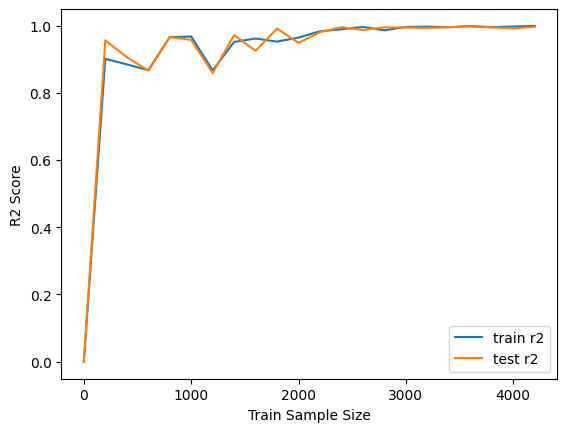

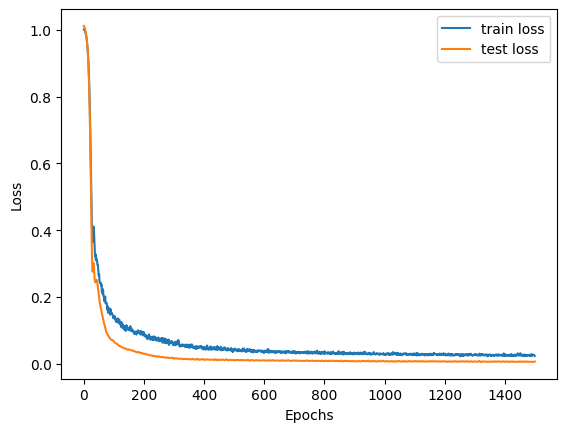

Train Loss: 0.0043
Test Loss: 0.0076
Train R-2 Score: 0.9957
Test R-2 Score: 0.9925


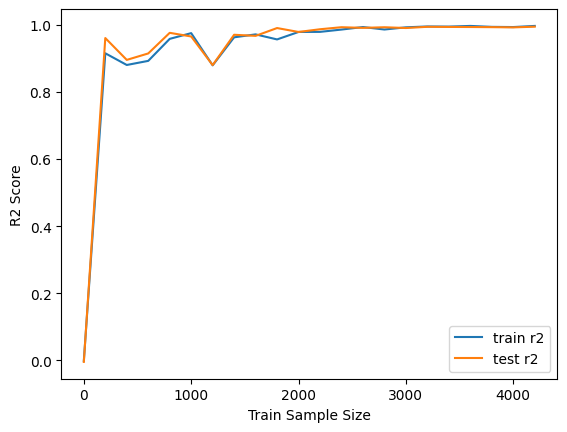

  adding: 15 Test - Seed 83/ (stored 0%)
  adding: 15 Test - Seed 83/Modelo 3 -  R2 x Train Sample  - 15 Test - Seed 83.png (deflated 10%)
  adding: 15 Test - Seed 83/Modelo 2 -  R2 x Train Sample  - 15 Test - Seed 83.png (deflated 9%)
  adding: 15 Test - Seed 83/Modelo 3 -  Loss x Epoch  - 15 Test - Seed 83.png (deflated 10%)
  adding: 15 Test - Seed 83/15 Test - Seed 83.txt (deflated 69%)
  adding: 15 Test - Seed 83/Modelo 1 -  Loss x Epoch  - 15 Test - Seed 83.png (deflated 10%)
  adding: 15 Test - Seed 83/Modelo 1 -  R2 x Train Sample  - 15 Test - Seed 83.png (deflated 9%)
  adding: 15 Test - Seed 83/Modelo 2 -  Loss x Epoch  - 15 Test - Seed 83.png (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

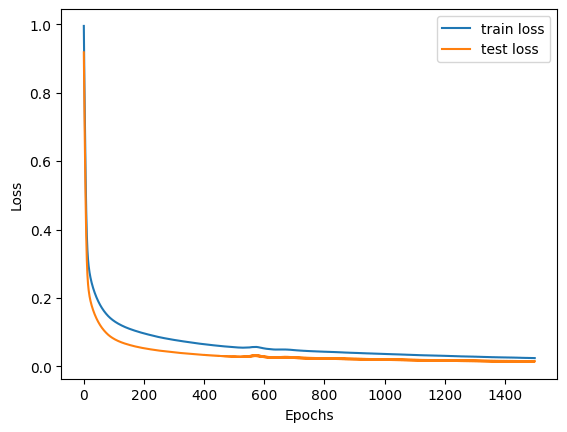

Train Loss: 0.0244
Test Loss: 0.0131
Train R-2 Score: 0.9756
Test R-2 Score: 0.9860


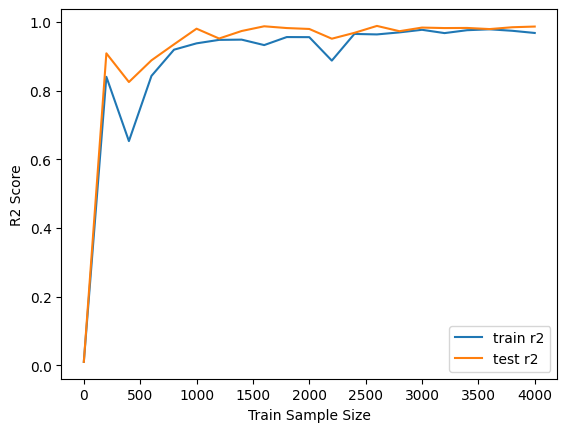

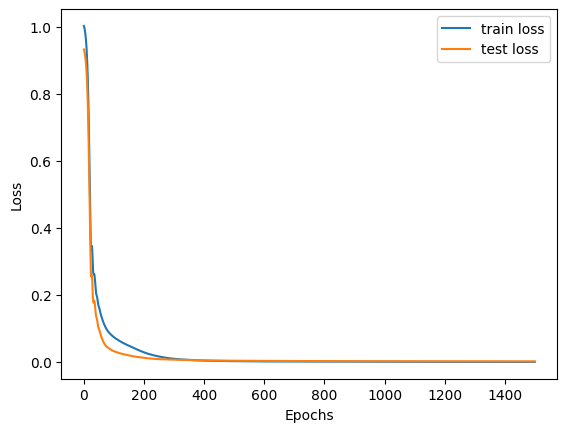

Train Loss: 0.0005
Test Loss: 0.0022
Train R-2 Score: 0.9995
Test R-2 Score: 0.9976


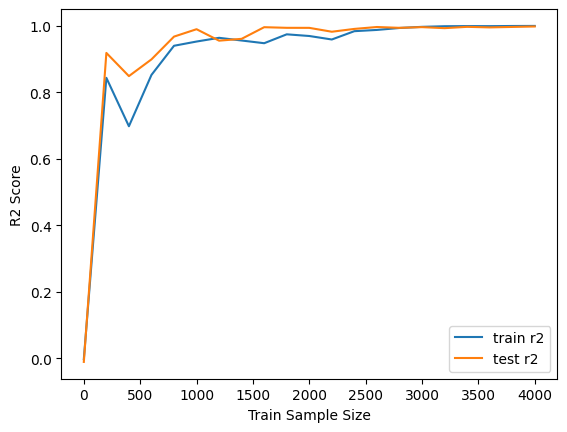

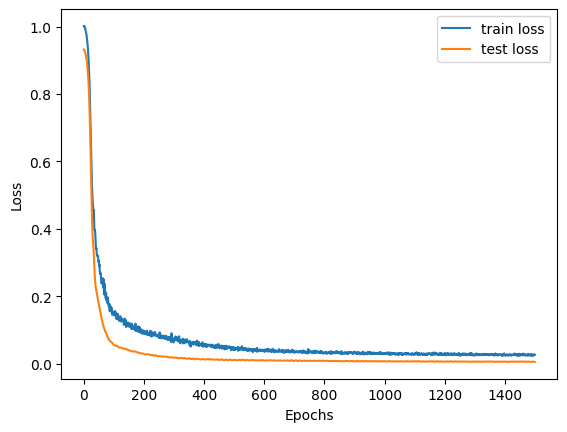

Train Loss: 0.0032
Test Loss: 0.0058
Train R-2 Score: 0.9968
Test R-2 Score: 0.9937


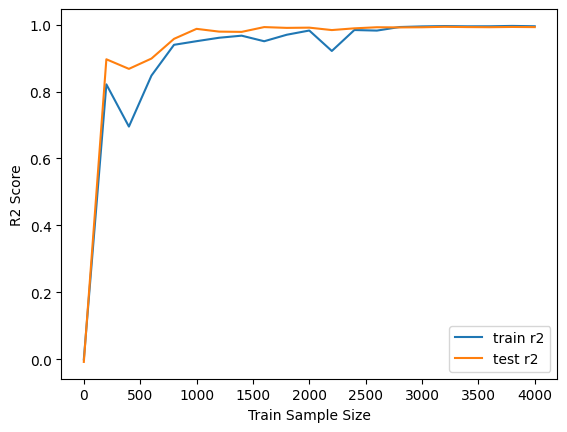

  adding: 20 Test - Seed 83/ (stored 0%)
  adding: 20 Test - Seed 83/Modelo 3 -  Loss x Epoch  - 20 Test - Seed 83.png (deflated 9%)
  adding: 20 Test - Seed 83/20 Test - Seed 83.txt (deflated 69%)
  adding: 20 Test - Seed 83/Modelo 2 -  R2 x Train Sample  - 20 Test - Seed 83.png (deflated 9%)
  adding: 20 Test - Seed 83/Modelo 1 -  Loss x Epoch  - 20 Test - Seed 83.png (deflated 10%)
  adding: 20 Test - Seed 83/Modelo 2 -  Loss x Epoch  - 20 Test - Seed 83.png (deflated 11%)
  adding: 20 Test - Seed 83/Modelo 1 -  R2 x Train Sample  - 20 Test - Seed 83.png (deflated 9%)
  adding: 20 Test - Seed 83/Modelo 3 -  R2 x Train Sample  - 20 Test - Seed 83.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

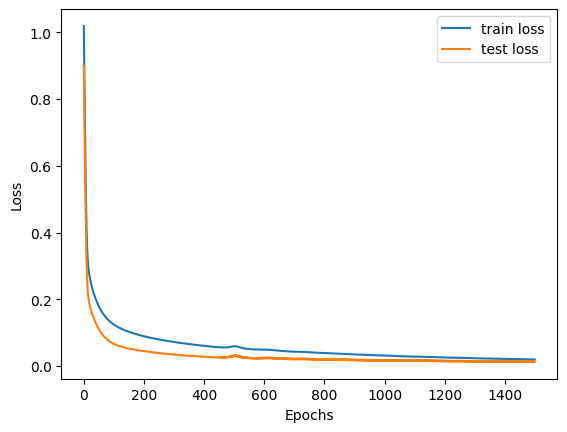

Train Loss: 0.0196
Test Loss: 0.0123
Train R-2 Score: 0.9804
Test R-2 Score: 0.9859


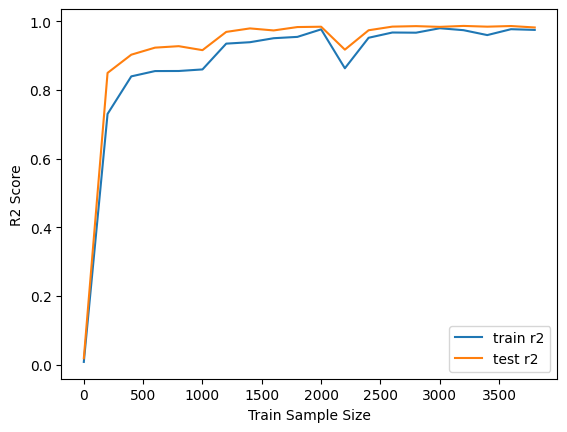

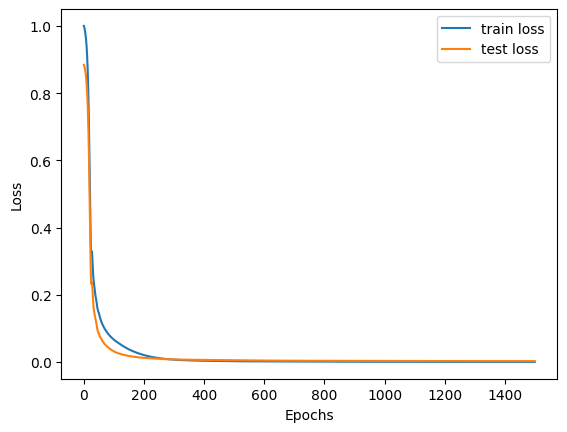

Train Loss: 0.0005
Test Loss: 0.0029
Train R-2 Score: 0.9995
Test R-2 Score: 0.9967


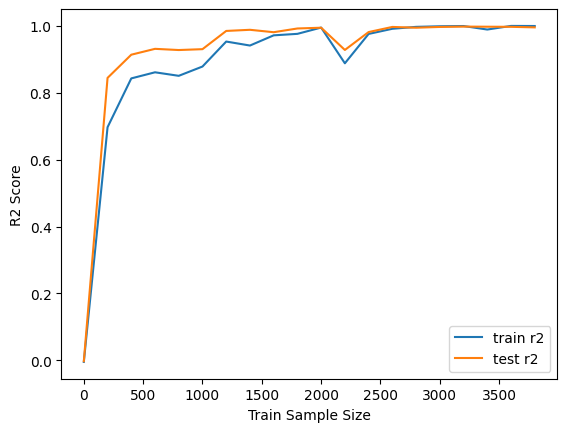

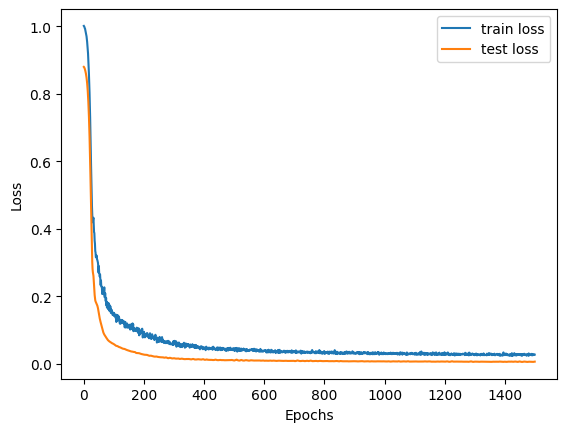

Train Loss: 0.0043
Test Loss: 0.0060
Train R-2 Score: 0.9957
Test R-2 Score: 0.9931


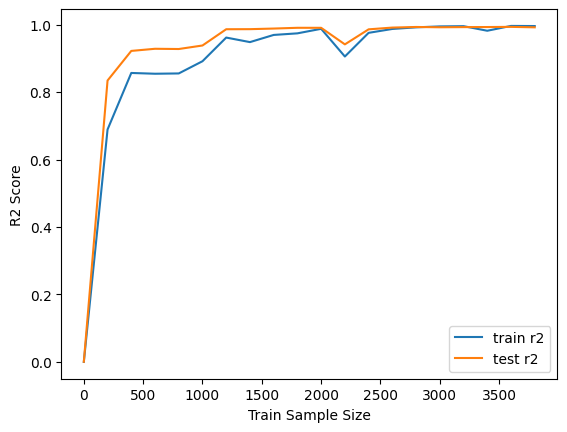

  adding: 25 Test - Seed 83/ (stored 0%)
  adding: 25 Test - Seed 83/Modelo 3 -  Loss x Epoch  - 25 Test - Seed 83.png (deflated 9%)
  adding: 25 Test - Seed 83/Modelo 2 -  Loss x Epoch  - 25 Test - Seed 83.png (deflated 11%)
  adding: 25 Test - Seed 83/25 Test - Seed 83.txt (deflated 70%)
  adding: 25 Test - Seed 83/Modelo 2 -  R2 x Train Sample  - 25 Test - Seed 83.png (deflated 9%)
  adding: 25 Test - Seed 83/Modelo 1 -  Loss x Epoch  - 25 Test - Seed 83.png (deflated 11%)
  adding: 25 Test - Seed 83/Modelo 3 -  R2 x Train Sample  - 25 Test - Seed 83.png (deflated 9%)
  adding: 25 Test - Seed 83/Modelo 1 -  R2 x Train Sample  - 25 Test - Seed 83.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

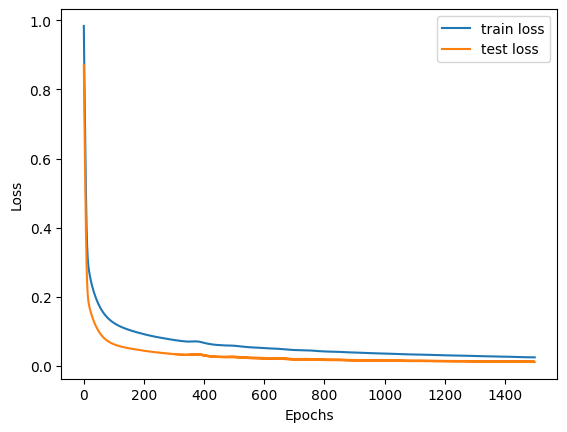

Train Loss: 0.0250
Test Loss: 0.0131
Train R-2 Score: 0.9750
Test R-2 Score: 0.9847


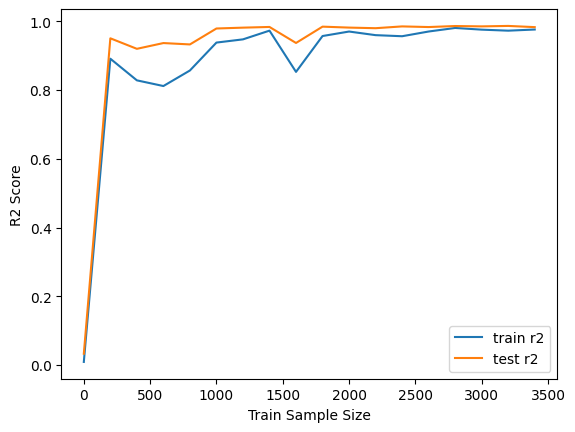

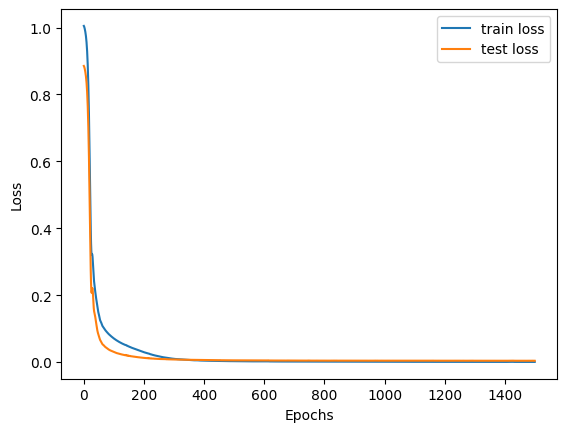

Train Loss: 0.0005
Test Loss: 0.0040
Train R-2 Score: 0.9995
Test R-2 Score: 0.9951


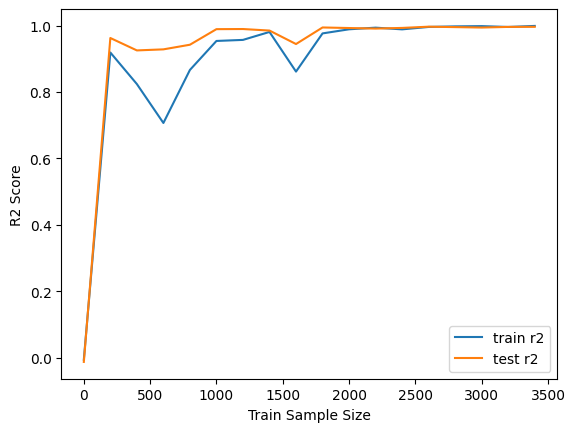

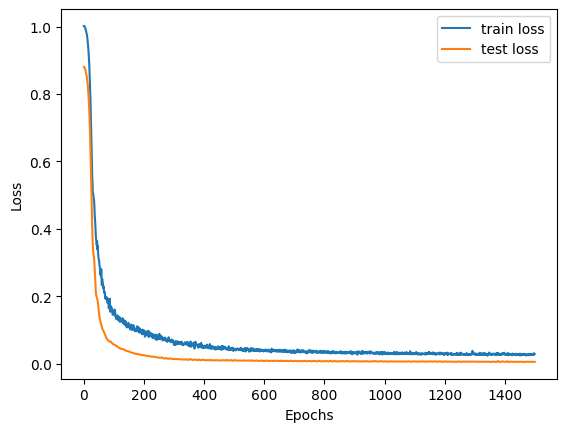

Train Loss: 0.0034
Test Loss: 0.0052
Train R-2 Score: 0.9966
Test R-2 Score: 0.9940


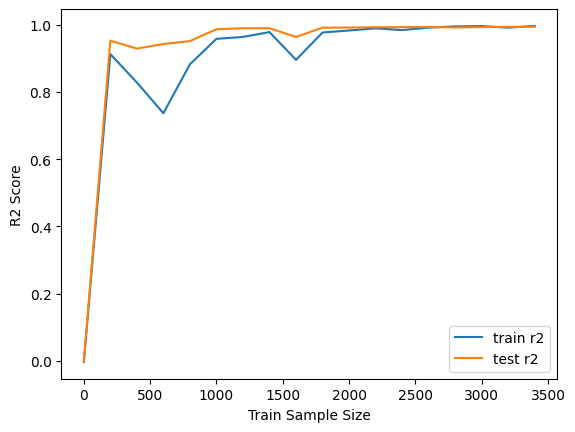

  adding: 30 Test - Seed 83/ (stored 0%)
  adding: 30 Test - Seed 83/Modelo 2 -  R2 x Train Sample  - 30 Test - Seed 83.png (deflated 10%)
  adding: 30 Test - Seed 83/Modelo 2 -  Loss x Epoch  - 30 Test - Seed 83.png (deflated 11%)
  adding: 30 Test - Seed 83/Modelo 3 -  R2 x Train Sample  - 30 Test - Seed 83.png (deflated 9%)
  adding: 30 Test - Seed 83/30 Test - Seed 83.txt (deflated 70%)
  adding: 30 Test - Seed 83/Modelo 3 -  Loss x Epoch  - 30 Test - Seed 83.png (deflated 10%)
  adding: 30 Test - Seed 83/Modelo 1 -  Loss x Epoch  - 30 Test - Seed 83.png (deflated 10%)
  adding: 30 Test - Seed 83/Modelo 1 -  R2 x Train Sample  - 30 Test - Seed 83.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

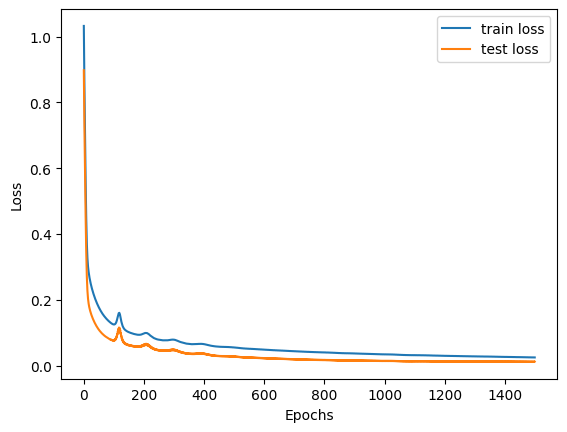

Train Loss: 0.0248
Test Loss: 0.0111
Train R-2 Score: 0.9752
Test R-2 Score: 0.9870


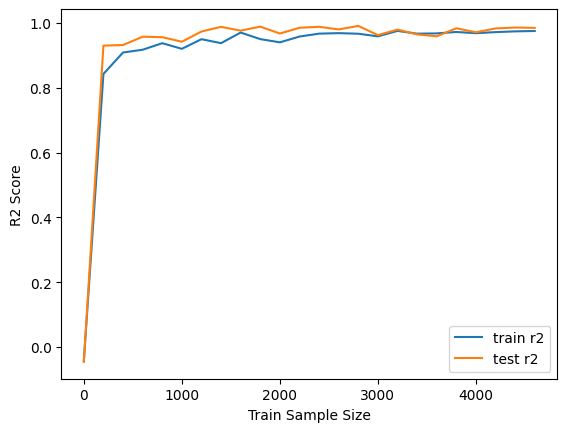

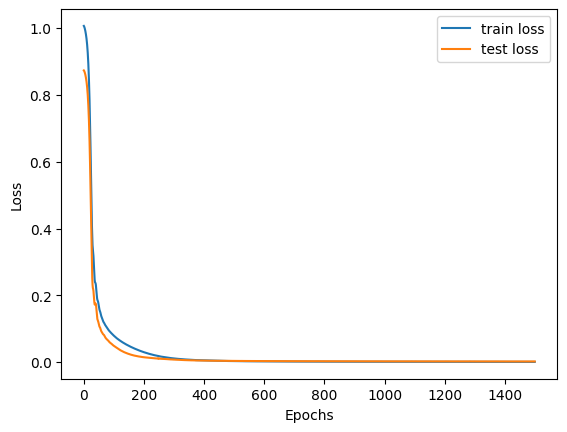

Train Loss: 0.0006
Test Loss: 0.0020
Train R-2 Score: 0.9994
Test R-2 Score: 0.9977


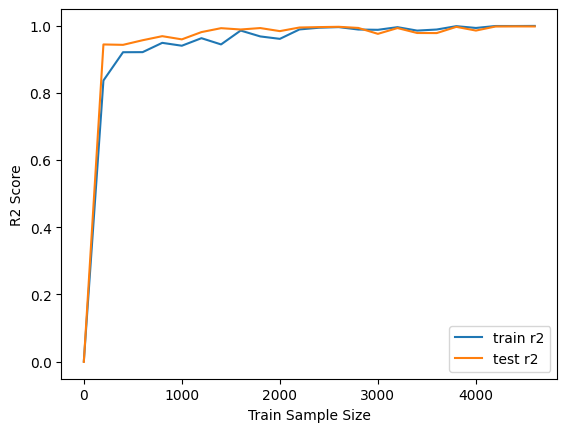

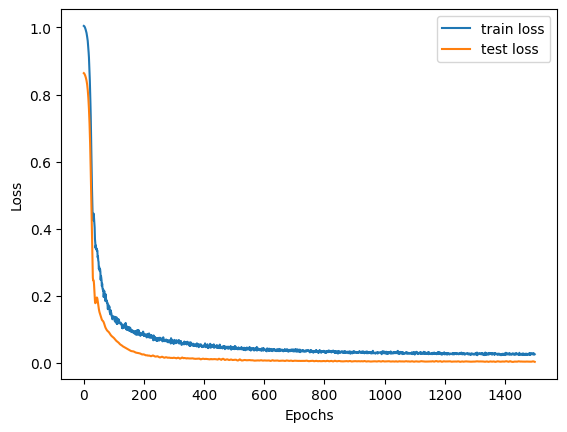

Train Loss: 0.0031
Test Loss: 0.0036
Train R-2 Score: 0.9969
Test R-2 Score: 0.9959


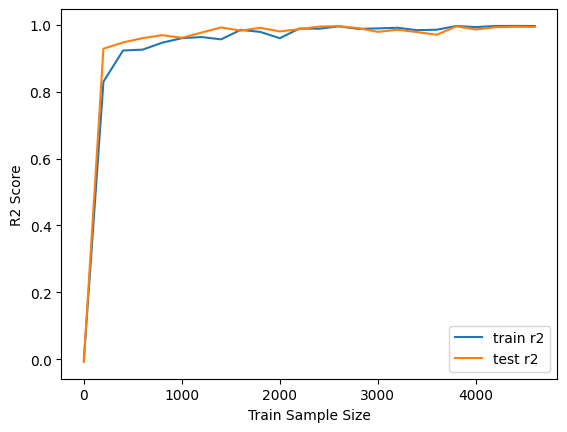

  adding: 10 Test - Seed 13/ (stored 0%)
  adding: 10 Test - Seed 13/Modelo 3 -  Loss x Epoch  - 10 Test - Seed 13.png (deflated 10%)
  adding: 10 Test - Seed 13/10 Test - Seed 13.txt (deflated 69%)
  adding: 10 Test - Seed 13/Modelo 1 -  Loss x Epoch  - 10 Test - Seed 13.png (deflated 10%)
  adding: 10 Test - Seed 13/Modelo 3 -  R2 x Train Sample  - 10 Test - Seed 13.png (deflated 10%)
  adding: 10 Test - Seed 13/Modelo 2 -  Loss x Epoch  - 10 Test - Seed 13.png (deflated 10%)
  adding: 10 Test - Seed 13/Modelo 2 -  R2 x Train Sample  - 10 Test - Seed 13.png (deflated 11%)
  adding: 10 Test - Seed 13/Modelo 1 -  R2 x Train Sample  - 10 Test - Seed 13.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

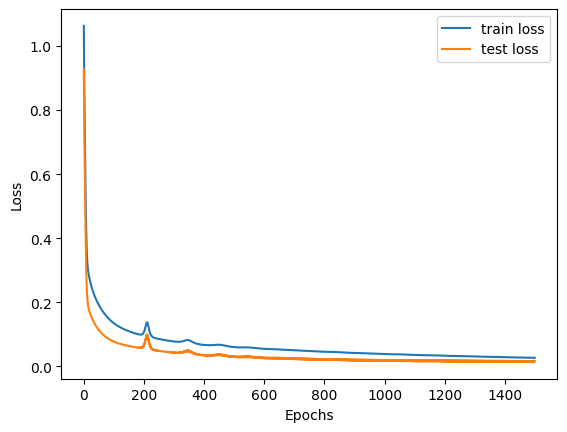

Train Loss: 0.0270
Test Loss: 0.0141
Train R-2 Score: 0.9730
Test R-2 Score: 0.9838


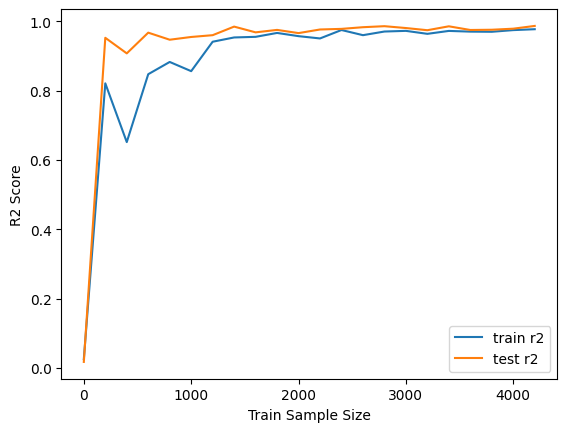

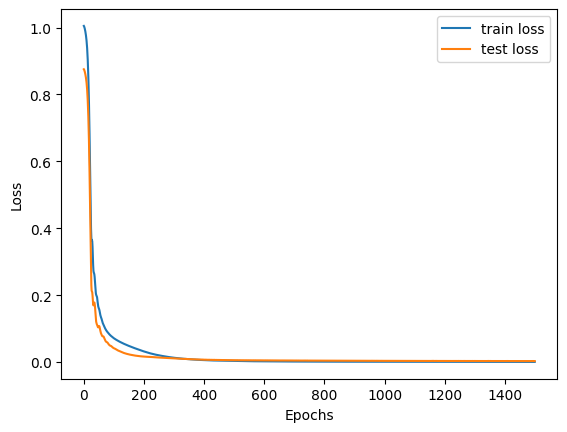

Train Loss: 0.0006
Test Loss: 0.0032
Train R-2 Score: 0.9994
Test R-2 Score: 0.9964


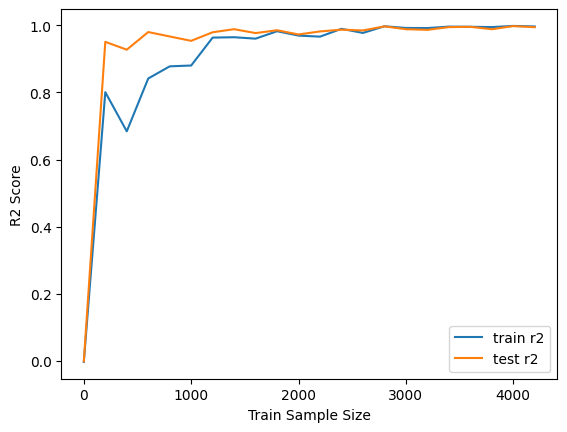

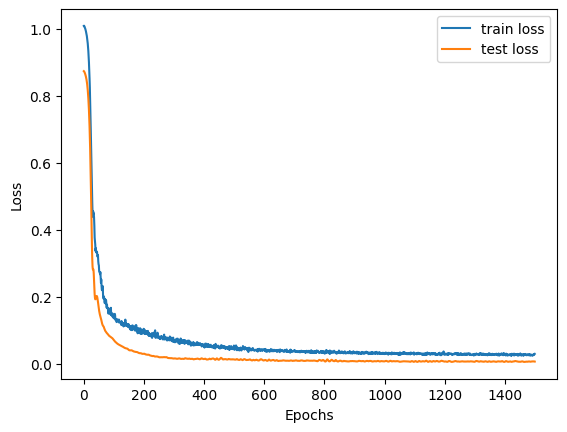

Train Loss: 0.0031
Test Loss: 0.0054
Train R-2 Score: 0.9969
Test R-2 Score: 0.9938


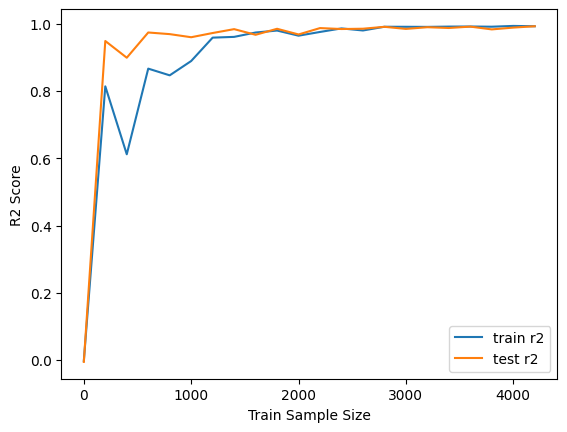

  adding: 15 Test - Seed 13/ (stored 0%)
  adding: 15 Test - Seed 13/Modelo 2 -  Loss x Epoch  - 15 Test - Seed 13.png (deflated 10%)
  adding: 15 Test - Seed 13/Modelo 2 -  R2 x Train Sample  - 15 Test - Seed 13.png (deflated 10%)
  adding: 15 Test - Seed 13/Modelo 3 -  Loss x Epoch  - 15 Test - Seed 13.png (deflated 9%)
  adding: 15 Test - Seed 13/15 Test - Seed 13.txt (deflated 70%)
  adding: 15 Test - Seed 13/Modelo 1 -  Loss x Epoch  - 15 Test - Seed 13.png (deflated 10%)
  adding: 15 Test - Seed 13/Modelo 1 -  R2 x Train Sample  - 15 Test - Seed 13.png (deflated 9%)
  adding: 15 Test - Seed 13/Modelo 3 -  R2 x Train Sample  - 15 Test - Seed 13.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

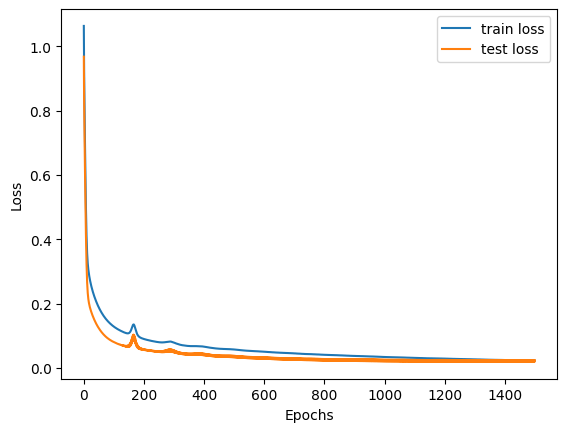

Train Loss: 0.0225
Test Loss: 0.0187
Train R-2 Score: 0.9775
Test R-2 Score: 0.9796


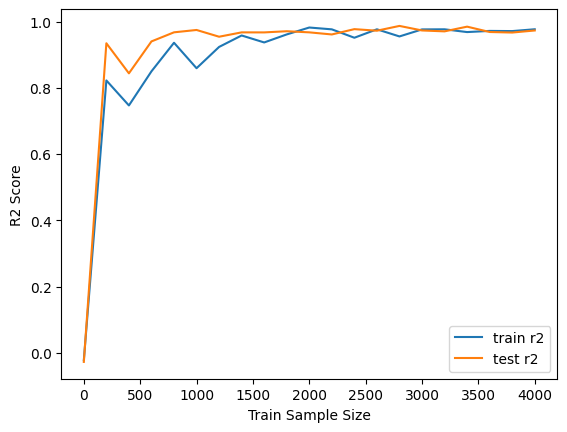

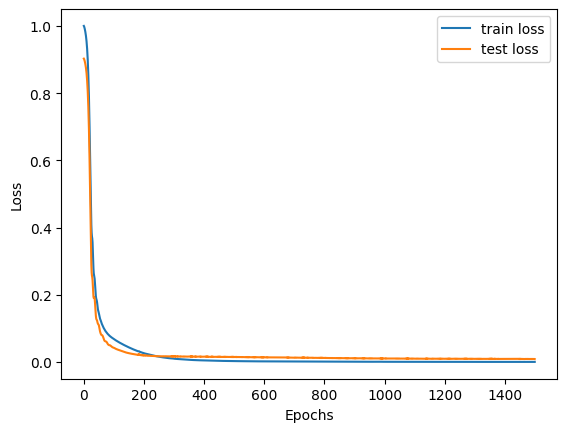

Train Loss: 0.0006
Test Loss: 0.0095
Train R-2 Score: 0.9994
Test R-2 Score: 0.9896


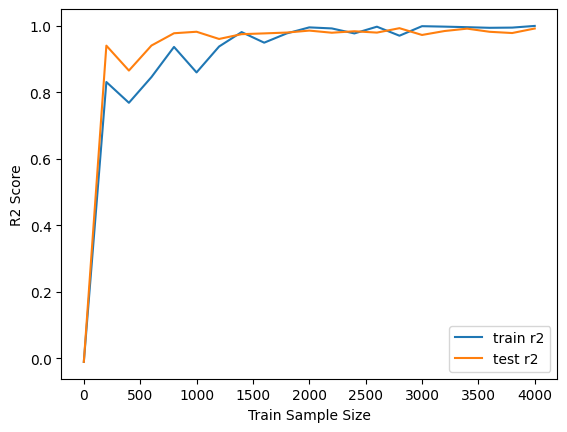

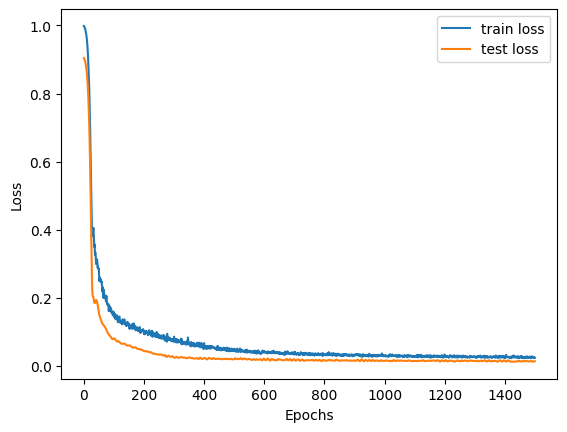

Train Loss: 0.0040
Test Loss: 0.0141
Train R-2 Score: 0.9960
Test R-2 Score: 0.9847


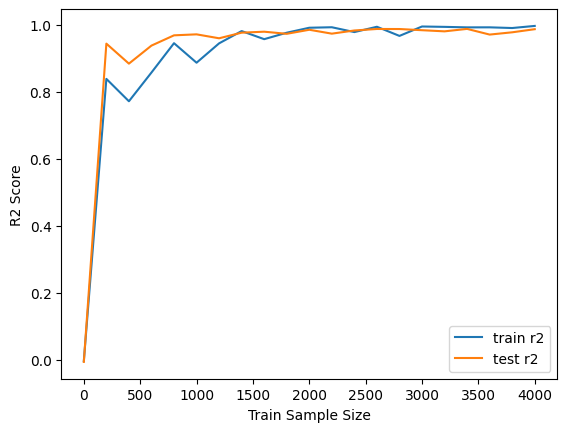

  adding: 20 Test - Seed 13/ (stored 0%)
  adding: 20 Test - Seed 13/Modelo 2 -  Loss x Epoch  - 20 Test - Seed 13.png (deflated 11%)
  adding: 20 Test - Seed 13/Modelo 1 -  Loss x Epoch  - 20 Test - Seed 13.png (deflated 10%)
  adding: 20 Test - Seed 13/Modelo 2 -  R2 x Train Sample  - 20 Test - Seed 13.png (deflated 9%)
  adding: 20 Test - Seed 13/Modelo 3 -  Loss x Epoch  - 20 Test - Seed 13.png (deflated 9%)
  adding: 20 Test - Seed 13/20 Test - Seed 13.txt (deflated 70%)
  adding: 20 Test - Seed 13/Modelo 1 -  R2 x Train Sample  - 20 Test - Seed 13.png (deflated 9%)
  adding: 20 Test - Seed 13/Modelo 3 -  R2 x Train Sample  - 20 Test - Seed 13.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

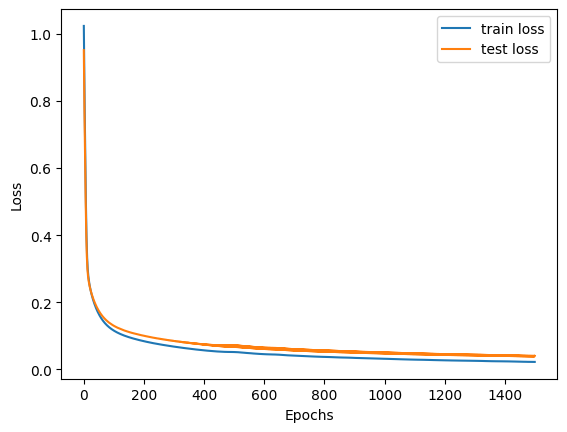

Train Loss: 0.0224
Test Loss: 0.0385
Train R-2 Score: 0.9776
Test R-2 Score: 0.9570


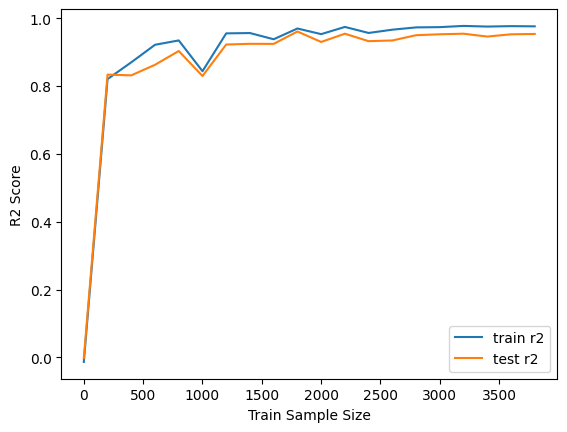

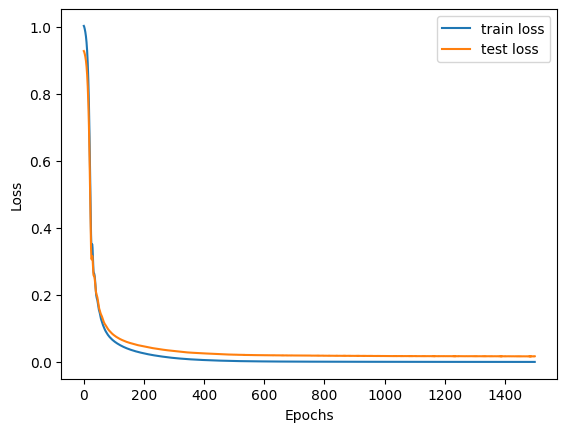

Train Loss: 0.0004
Test Loss: 0.0169
Train R-2 Score: 0.9996
Test R-2 Score: 0.9812


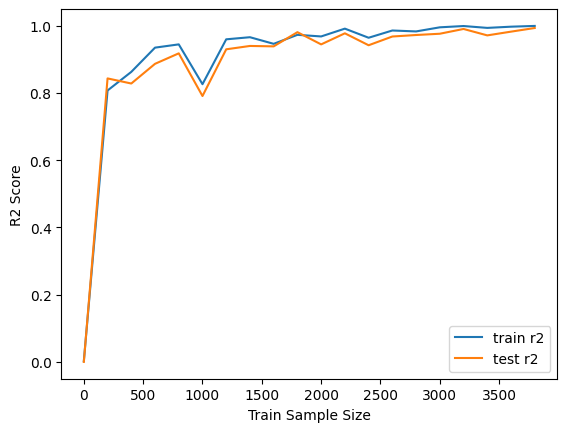

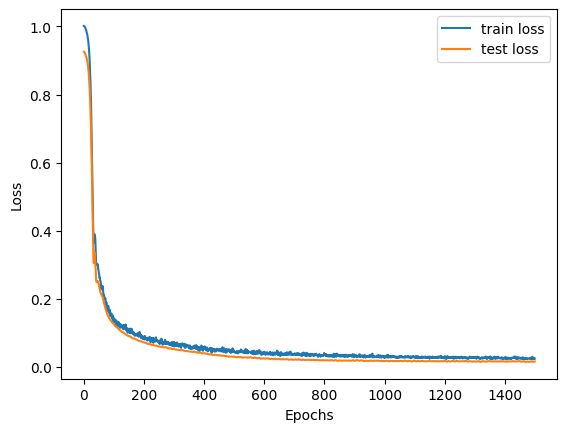

Train Loss: 0.0036
Test Loss: 0.0163
Train R-2 Score: 0.9964
Test R-2 Score: 0.9819


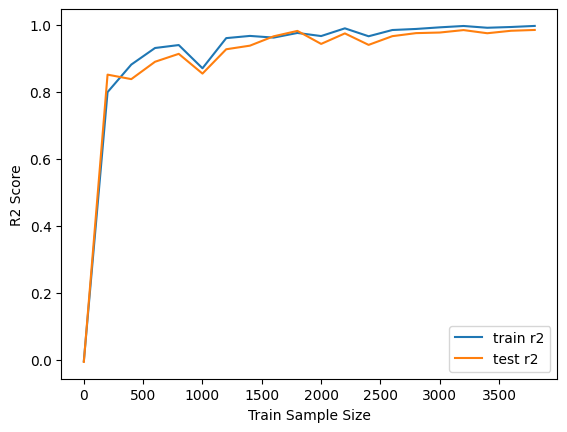

  adding: 25 Test - Seed 13/ (stored 0%)
  adding: 25 Test - Seed 13/Modelo 1 -  R2 x Train Sample  - 25 Test - Seed 13.png (deflated 10%)
  adding: 25 Test - Seed 13/Modelo 2 -  R2 x Train Sample  - 25 Test - Seed 13.png (deflated 9%)
  adding: 25 Test - Seed 13/Modelo 2 -  Loss x Epoch  - 25 Test - Seed 13.png (deflated 11%)
  adding: 25 Test - Seed 13/Modelo 3 -  R2 x Train Sample  - 25 Test - Seed 13.png (deflated 9%)
  adding: 25 Test - Seed 13/25 Test - Seed 13.txt (deflated 70%)
  adding: 25 Test - Seed 13/Modelo 3 -  Loss x Epoch  - 25 Test - Seed 13.png (deflated 10%)
  adding: 25 Test - Seed 13/Modelo 1 -  Loss x Epoch  - 25 Test - Seed 13.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

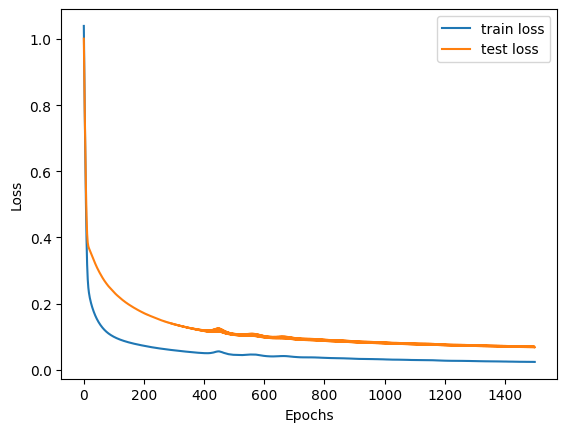

Train Loss: 0.0235
Test Loss: 0.0702
Train R-2 Score: 0.9765
Test R-2 Score: 0.9232


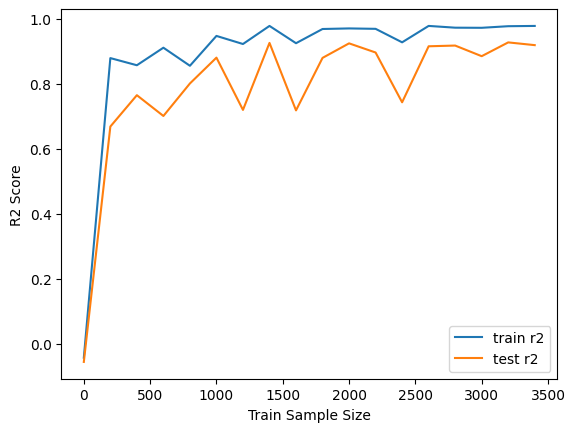

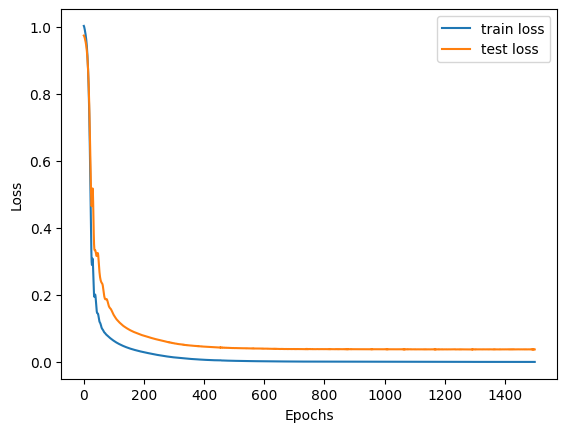

Train Loss: 0.0005
Test Loss: 0.0379
Train R-2 Score: 0.9995
Test R-2 Score: 0.9568


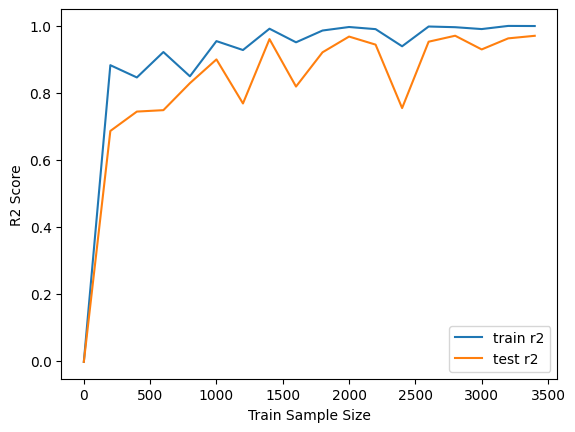

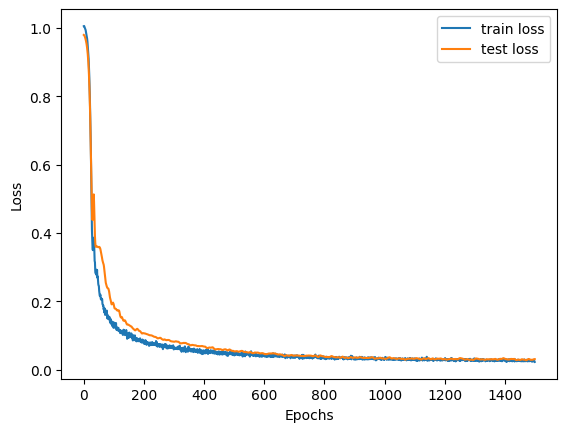

Train Loss: 0.0032
Test Loss: 0.0303
Train R-2 Score: 0.9968
Test R-2 Score: 0.9666


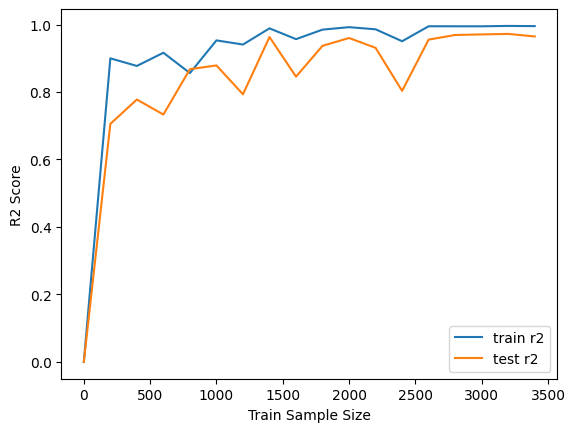

  adding: 30 Test - Seed 13/ (stored 0%)
  adding: 30 Test - Seed 13/Modelo 2 -  R2 x Train Sample  - 30 Test - Seed 13.png (deflated 7%)
  adding: 30 Test - Seed 13/Modelo 1 -  Loss x Epoch  - 30 Test - Seed 13.png (deflated 10%)
  adding: 30 Test - Seed 13/Modelo 1 -  R2 x Train Sample  - 30 Test - Seed 13.png (deflated 8%)
  adding: 30 Test - Seed 13/Modelo 3 -  Loss x Epoch  - 30 Test - Seed 13.png (deflated 10%)
  adding: 30 Test - Seed 13/Modelo 3 -  R2 x Train Sample  - 30 Test - Seed 13.png (deflated 8%)
  adding: 30 Test - Seed 13/Modelo 2 -  Loss x Epoch  - 30 Test - Seed 13.png (deflated 10%)
  adding: 30 Test - Seed 13/30 Test - Seed 13.txt (deflated 70%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
criterions = [criterion1, criterion2, criterion3]
optimizers = [optimizer1, optimizer2, optimizer3]

seeds =  [25, 31, 83, 13]
test_sizes = [10, 15, 20, 25, 30]

for seed in seeds:
  for test_size in test_sizes:
    saving_all(models, criterions, optimizers, inputs_tensor, outputs_tensor, test_size, seed)